In [2]:
import h5py
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.metrics import *
from sklearn.neighbors import *
from sklearn.pipeline import *
from tensorflow import keras
from FAST_master.model.threedcnn.img_util import voxelize_3d
from tensorflow.keras.metrics import *
from scipy.ndimage.interpolation import rotate

train = h5py.File("OneDrive_1_7-21-2022/postera_protease2_pos_neg_train.hdf5", "r")
validation = h5py.File("OneDrive_1_7-21-2022/postera_protease2_pos_neg_val.hdf5", "r")
test = h5py.File("OneDrive_1_7-21-2022/postera_protease2_pos_neg_test.hdf5", "r")

# Functions

In [7]:
def data(file):
    listKeys = list(file.keys())
    data = np.zeros((len(listKeys), 100, 22))
    i = 0
    for key in listKeys:
        data[i] = file[key]["ligand"].value # add atoms data
        i += 1
    return data

def labels(file): # get each ligand's associated label (overall)
    labels = []
    for key in file.keys():
        labels.append(file[key].attrs["label"])
    return np.array(labels)

def voxelize(file = None, dim = [19, 10, 10, 10], do_data = None): # create voxelized cube data for the input of the model in 19x10x10x10 format
    d = None
    if do_data is not None:
        d = do_data
    elif file is not None:
        d = data(file)
    else:
        return
        
    voxelized = np.zeros((d.shape[0], dim[0], dim[1], dim[2], dim[3]))
    for i in range(d.shape[0]): # iterate for each ligand
        voxelized[i] = voxelize_3d(xyz=d[i, :, 0:3], feat=d[i, :, 3:], vol_dim=dim)
    if file is not None:
        return [voxelized, labels(file)]
    return voxelized

In [8]:
# voxelize other things
train_things = voxelize(train)
train_arr = train_things[0]
train_labels = train_things[1]

/Users/sucheen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


# Fit Model

In [4]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [9]:
voxelize_validation = voxelize(validation)
validation_voxel = voxelize_validation[0]
validation_label = voxelize_validation[1]

/Users/sucheen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [6]:
# https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

model = Sequential()
shape = (19, 10, 10, 10)
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
fitted = model.fit(voxelized_train, np.array(train_labels),
            batch_size=256,
            epochs=200,
            verbose=1,
            validation_data = (validation_voxel, validation_label))

"model = Sequential()\nshape = (19, 10, 10, 10)\nmodel.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=shape))\nmodel.add(MaxPooling3D(pool_size=(2, 2, 2)))\nmodel.add(BatchNormalization(center=True, scale=True))\nmodel.add(Dropout(0.5))\nmodel.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))\nmodel.add(MaxPooling3D(pool_size=(2, 2, 2)))\nmodel.add(BatchNormalization(center=True, scale=True))\nmodel.add(Dropout(0.5))\nmodel.add(Flatten())\nmodel.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))\nmodel.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))\nmodel.add(Dense(10, activation='softmax'))\n\nmodel.compile(loss='sparse_categorical_crossentropy',\n              optimizer=keras.optimizers.Adam(lr=0.001),\n              metrics=['accuracy'])\nfitted = model.fit(voxelized_train, np.array(train_labels),\n            batch_size=256,\n            epochs=200,\

In [7]:
model = load_model("model.h5")
model.save("model.h5")

In [8]:
def cv(train, labels, v = 10):
    if len(train) != len(labels):
        raise ValueError("length mismatch")
    i = 0
    j = len(train)//v
    arr = list(np.arange(0, len(train), 1))
    test_index = [ind for ind in arr if not (ind >= i and ind <= j)]
    fold_train = train[i:j+1]
    fold_train_labels = labels[i:j+1]
    fold_test = train[test_index]
    fold_test_labels = labels[test_index]
    accuracies = []
    
    model = Sequential()
    shape = (19, 10, 10, 10)
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    accuracies = np.array([])
    while j < len(train):
        print(f"{i} to {j}")
        model.fit(fold_train, fold_train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data = (fold_test, fold_test_labels))
        predictions = model.predict_classes(fold_test)
        acc = accuracy_score(y_true = fold_test_labels, y_pred=predictions)
        accuracies = np.append(accuracies, acc)
        i = j
        j += len(train)//v
    return np.mean(accuracies)
    
#cv(train = voxelized_train, labels = labels(train), v=50)

In [9]:

validation_label

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
accuracy_score(y_true = labels(validation), y_pred=model.predict_classes(validation_voxel))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.7221238938053097

In [11]:
import sklearn
from sklearn.metrics import *
p = model.predict_proba(validation_voxel)
roc_auc_score(y_true = labels(validation), y_score = p[:, 1])

print(confusion_matrix(y_true = labels(test), y_pred=model.predict_classes(voxelize(test)[0])))

Instructions for updating:
Please use `model.predict()` instead.


/Users/sucheen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


[[432 168]
 [268 412]]


In [10]:
# test accuracy
test_items = voxelize(test)
pred = model.predict_classes(test_items[0])
actual = labels(validation)
round(roc_auc_score(actual, model.predict_proba(validation_voxel)[:, 1]), 3)

/Users/sucheen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.


0.786

In [13]:
matthews_corrcoef(validation_label, model.predict_classes(validation_voxel))

0.43802360527114936

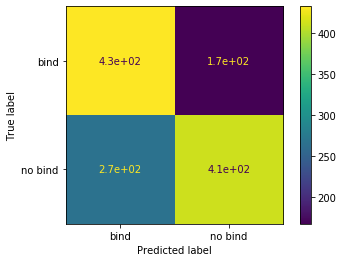

In [31]:
cm = confusion_matrix(y_true=labels(test), y_pred=model.predict_classes(test_items[0]))
ConfusionMatrixDisplay(cm, display_labels = ["bind", "no bind"]).plot()

In [5]:
model = load_model("model.h5")

# Rotate Ligands

## post-voxelization 

In [16]:
train_arr = data(train) # non-voxelized
theta = np.deg2rad(30)

/Users/sucheen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [17]:
angle = np.random.randint(360)
len(np.unique(train_arr))

1505174

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
size = 5
for i in np.random.randint(len(train), size=size):
    figure = plt.figure(figsize=(7, 7))
    axis = figure.add_subplot(111, projection="3d")
    x = train_arr[i, :, 0]
    y = train_arr[i, :, 1]
    z = train_arr[i, :, 2]
    axis.scatter(x, y, z)
    axis.set_xlabel("x")
    axis.set_ylabel("y")
    axis.set_zlabel("z")
    axis.set_title(f"ligand {i}")
    figure.show()

In [ ]:
from sklearn.metrics import *
plot = ConfusionMatrixDisplay(confusion_matrix(y_true = labels(test), y_pred=model.predict_classes(test_items[0])), display_labels=["1", "0"])
plot.plot(cmap='Blues')

In [ ]:
dim1s = pd.Series(index = list(range(360)))
from IPython.display import clear_output
for theta in range(1, 360):
    print(theta)
    dim1s[theta] = rotate(data(train), angle=theta).shape[0]
    clear_output(wait=True)
dim1s.idxmax()

51


In [69]:
roc_auc_score(y_true=labels(validation), y_score=model.predict_proba(validation_voxel)[:, 1])

0.7857479443390261

Text(0, 0.5, 'TPR')

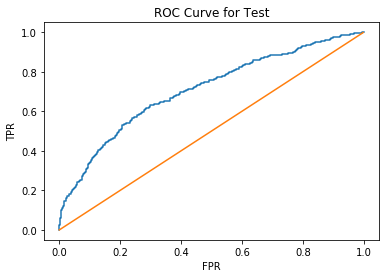

In [123]:
import matplotlib.pyplot as plt
fpr, tpr, item = roc_curve(y_true=labels(test), y_score=model.predict_proba(test_items[0])[:, 1])
plt.plot(fpr, tpr)
arr = np.arange(0, 1, 1/len(fpr))
plt.plot(arr, arr)
plt.title("ROC Curve for Test")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [124]:
roc_auc_score(y_true=labels(test), y_score=model.predict_proba(test_items[0])[:, 1])

0.7075392156862745

In [125]:
print(classification_report(y_true = labels(test), y_pred = model.predict_classes(test_items[0])))

              precision    recall  f1-score   support

           0       0.62      0.72      0.66       600
           1       0.71      0.61      0.65       680

    accuracy                           0.66      1280
   macro avg       0.66      0.66      0.66      1280
weighted avg       0.67      0.66      0.66      1280

